# Multivariate time series forecasting using LSTM using cycle-feature.

In [53]:
%reset -f
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 10,10
from sklearn.preprocessing import StandardScaler 
from functionsAll import lstmMultiSplit, originalToRecurring, recurringToOrignal
import warnings
warnings.filterwarnings('ignore')

## Data cleaning.

In [54]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [55]:
cyDf = df[['day','month','dayofyear','weekday', 'week', 'hour']] # [32,13,367,7,54,52]
scDf = df[['wert','year' , 'temp', 'dwpt', 'rhum', 'prcp']]

## Data normalizing

In [56]:
day = cyDf['day']
day.to_numpy()
day = originalToRecurring(ogUnits=day,period=32)
cyDf['day_sin'] = day[:,0]
cyDf['day_cos'] = day[:,1]

month = cyDf['month']
month.to_numpy()
month = originalToRecurring(ogUnits=month,period=13)
cyDf['month_sin'] = month[:,0]
cyDf['month_cos'] = month[:,1]

dayofyear = cyDf['dayofyear']
dayofyear.to_numpy()
dayofyear = originalToRecurring(ogUnits=dayofyear,period=367)
cyDf['dayofyear_sin'] = dayofyear[:,0]
cyDf['dayofyear_cos'] = dayofyear[:,1]

weekday = cyDf['weekday']
weekday.to_numpy()
weekday = originalToRecurring(ogUnits=weekday,period=7)
cyDf['weekday_sin'] = weekday[:,0]
cyDf['weekday_cos'] = weekday[:,1]

week = cyDf['week']
week.to_numpy()
week = originalToRecurring(ogUnits=week,period=54)
cyDf['week_sin'] = week[:,0]
cyDf['week_cos'] = week[:,1]

hour = cyDf['hour']
hour.to_numpy()
hour = originalToRecurring(ogUnits=hour,period=25)
cyDf['hour_sin'] = hour[:,0]
cyDf['hour_cos'] = hour[:,1]

In [57]:
cyDf.drop(['day', 'month', 'dayofyear', 'weekday', 'week','hour'], axis=1, inplace=True)

In [58]:
cyDf.columns

Index(['day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin',
       'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [61]:
scaler = StandardScaler()
scaler = scaler.fit(scDf)
scaledDf = scaler.transform(scDf)

### Combine in one dataframe. [cycle + normalize]

In [62]:
cyDf['wert'] = scaledDf[:,0]
cyDf['year'] = scaledDf[:,1]
cyDf['temp'] = scaledDf[:,2]
cyDf['dwpt'] = scaledDf[:,3]
cyDf['rhum'] = scaledDf[:,4]
cyDf['prcp'] = scaledDf[:,5]
mainDf = cyDf[['wert','day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin',
        'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
        'hour_sin', 'hour_cos', 'temp', 'dwpt', 'rhum', 'prcp']]

In [63]:
mainDf.head(5)

,wert,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,week_sin,week_cos,hour_sin,hour_cos,temp,dwpt,rhum,prcp
0,1.680347,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.000000,1.000000,-1.566281,-1.385630,0.792786,-0.154285
1,1.188967,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.982287,-0.187381,-1.691633,-1.490882,0.903869,-0.154285
2,1.287243,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.998027,0.062791,-1.747346,-1.508424,1.014952,-0.154285
3,0.795863,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.951057,0.309017,-1.775202,-1.490882,1.126034,-0.154285
4,1.876899,0.382683,0.92388,0.464723,0.885456,0.034234,0.999414,0.433884,-0.900969,0.116093,0.993238,0.844328,0.535827,-1.761274,-1.420714,1.237117,-0.154285


## Data windowing and splitting

In [64]:
mianNp = mainDf.to_numpy()

In [65]:
train = mianNp[:23000]
test = mianNp[23000:] 

In [66]:
trainX, trainY = lstmMultiSplit(df=train, n_past=5, n_future=1)
testX, testY = lstmMultiSplit(df=test, n_past=5, n_future=1)

In [67]:
trainX.shape

(22995, 5, 17)

In [68]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            74752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 136,609
Trainable params: 136,609
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(trainX, trainY, epochs=30, batch_size=12, validation_split=0.1, verbose=1)

Epoch 1/30
1725/1725 [==============================] - 16s 8ms/step - loss: 0.5580 - val_loss: 0.2180
Epoch 2/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4866 - val_loss: 0.1981
Epoch 3/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4803 - val_loss: 0.1961
Epoch 4/30
1725/1725 [==============================] - 15s 9ms/step - loss: 0.4652 - val_loss: 0.1943
Epoch 5/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4585 - val_loss: 0.1935
Epoch 6/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4510 - val_loss: 0.1947
Epoch 7/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4538 - val_loss: 0.2035
Epoch 8/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4396 - val_loss: 0.2013
Epoch 9/30
1725/1725 [==============================] - 14s 8ms/step - loss: 0.4323 - val_loss: 0.1956
Epoch 10/30
1725/1725 [==============================] - 14s 8ms/step - l

In [89]:
print(f"Train accuracy using LSTM and cycle-feature: {model.evaluate(trainX, trainY,batch_size=64)*100:.2f}%")

print(f"Test accuracy using LSTM and cycle-feature:: {model.evaluate(testX, testY,batch_size=64)*100:.2f}%")

 14/360 [>.............................] - ETA: 1s - loss: 0.2614

360/360 [==============================] - 1s 3ms/step - loss: 0.2122
Train accuracy using LSTM and cycle-feature: 21.22%
12/12 [==============================] - 0s 3ms/step - loss: 0.2559
Test accuracy using LSTM and cycle-feature:: 25.59%


- Train accuracy using LSTM with-out cycle-feature: 24.37%
- Test accuracy using LSTM with-out cycle-feature: 31.69%

- Train accuracy using LSTM with cycle-feature: 21.22%
- Test accuracy using LSTM with cycle-feature: 25.59%

In [81]:
prediction = model.predict(testX)

In [83]:
prediction = np.repeat(prediction, 6, axis=-1)
realPrediction = scaler.inverse_transform(prediction)
realPrediction = realPrediction[:,0]

In [84]:
yt = df.query('index >= 23000')
yt = yt['wert']
yt.reset_index(drop=True, inplace=True)

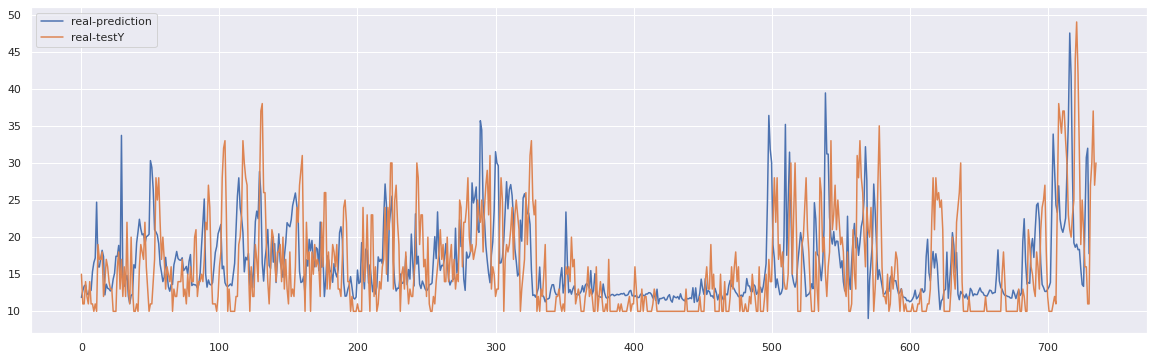

In [85]:
rcParams['figure.figsize'] = 20,6
plt.plot(realPrediction, label='real-prediction')
plt.plot(yt, label='real-testY')
plt.legend() 
plt.show()

In [86]:
pdf = pd.DataFrame(data=realPrediction,columns=['prediction'])
pdf['Real'] = yt
pdf['Error'] = pdf['prediction'] - pdf['Real']

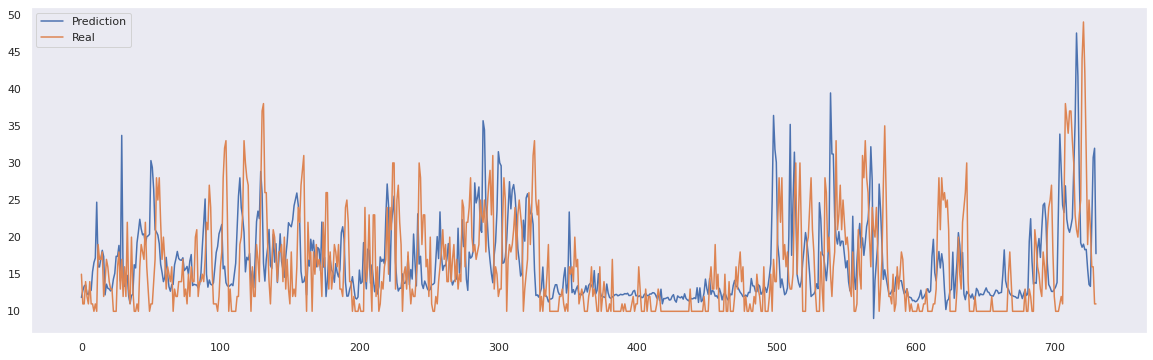

In [87]:
plt.plot(pdf.prediction, label='Prediction')
plt.plot(pdf.Real, label='Real')
plt.legend()
plt.grid()
plt.show()

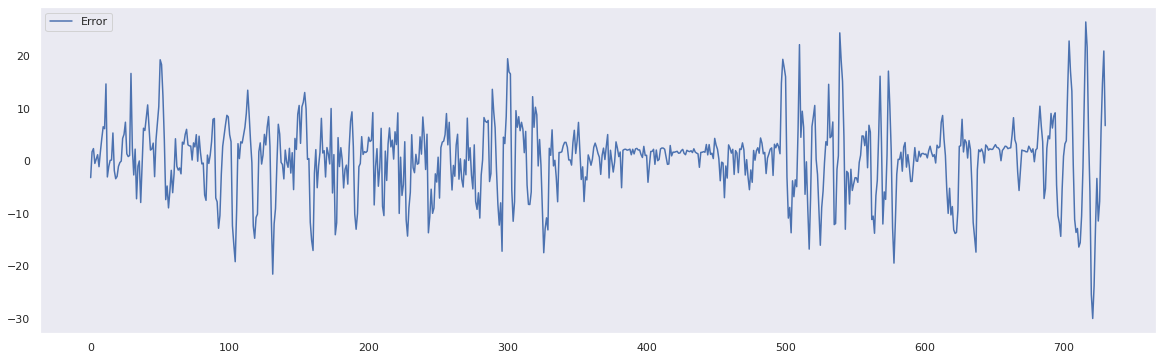

In [88]:
plt.plot(pdf.Error, label='Error')
plt.legend()
plt.grid()
plt.show()

In [91]:
model.save('../models/ml04-1/ml04-1.h5')

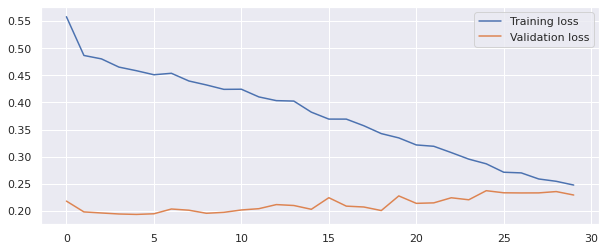

In [93]:
rcParams['figure.figsize'] = 10,4
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [95]:
pdf.to_csv('../models/ml04-1/predictions.csv', index=False)